In [7]:
#base imports
import os
import sys
import shutil

import numpy as np
import pandas as pd

import enlighten

from IPython.core.display import HTML

import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU
import torch_geometric.transforms as T
from torch_sparse import coalesce
from torch_geometric.data import (InMemoryDataset, Data, download_url)
from torch_scatter import scatter

from torch_geometric.nn import NNConv, Set2Set
# from torch_geometric.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.utils import remove_self_loops

https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/datasets/qm9.html

https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html

https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.InMemoryDataset

https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/data/dataset.html#Dataset


In [8]:
#RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import PandasTools
from rdkit import RDLogger

RDLogger.logger().setLevel(RDLogger.CRITICAL)

In [9]:
#fcts
def show(df):
    """Render the molecules within a DataFrame correctly"""
    return HTML(df.to_html(notebook=True))


In [10]:
#check GPU
print(torch.cuda.is_available())

True


In [11]:
assay = 1511
global dataset
# filename = f'{assay}_dataset.pt'
dataset = f'{assay}_dataset.pt'
global input_sdf
input_sdf = f'{assay}_compounds.sdf'
global directory
directory = f'{assay}_data'

In [12]:
#setup dataset
sdfpath = os.path.join(os.getcwd(), f'{assay}_compounds.sdf')
backup_df = PandasTools.LoadSDF(sdfpath)
dataframe = backup_df.copy()

,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,ID,ROMol
0,1511,56314828,1988,Inactive,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,,
1,1511,56321651,425322,Inactive,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,,
2,1511,56322145,24981957,Inactive,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,,
3,1511,51090143,7384392,Inactive,CCS(=O)(=O)N1CCC2(CC1)N(CCO2)S(=O)(=O)C3=CC=C(...,,
4,1511,51090795,7423030,Inactive,CC1=NC(=NC=C1)NC(=O)CCN2C(=O)C3=CC=CC=C3S2(=O)=O,,

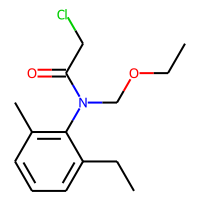
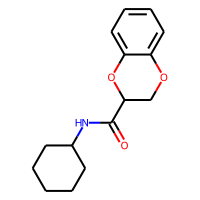
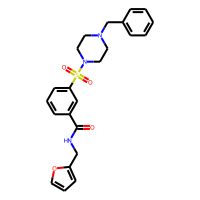
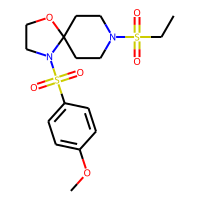
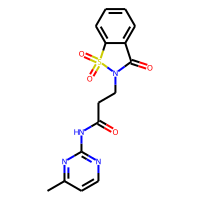

In [13]:
show(dataframe.head(5))

In [14]:
import csv

global element_dict
elements = []

if os.path.exists('element_list.json'):
    pass
else:
    with open('periodictable.csv', 'r') as ifile:
        reader = csv.reader(ifile)
        for i in reader:
            element = i[1]
            elements.append(element)

    indexes = [i for i in range(len(elements))]


    element_dict = dict(zip(elements, indexes))

In [15]:
#save to file for future use
import json

if os.path.exists('element_list.json'):
    with open('element_list.json', 'r') as listfile:
        element_dict = json.load(listfile)
else:
    with open('element_list.json', 'w') as listfile:
        json.dump(element_dict, listfile)

In [16]:
#setup filesystem
import shutil

rawdir = os.path.join(directory, 'raw')
processdir = os.path.join(directory, 'processed')

try:
    os.mkdir(directory)
    # rawdir = os.path.join(directory, 'raw')
    # processdir = os.path.join(directory, 'processed')
    os.mkdir(rawdir)
    os.mkdir(processdir)
except FileExistsError:
    print("Directory already exists")
    pass
finally:
    shutil.copyfile(os.path.abspath(input_sdf), os.path.join(rawdir, input_sdf))
    
    
    


In [17]:
dataframe["PUBCHEM_ACTIVITY_OUTCOME"].replace("Inactive", 0, inplace=True)
dataframe["PUBCHEM_ACTIVITY_OUTCOME"].replace("Active", 1, inplace=True)

In [18]:
dataframe.PUBCHEM_ACTIVITY_OUTCOME.value_counts()

0    304127
1      1552
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64

In [19]:
global targets
targets = dataframe.PUBCHEM_ACTIVITY_OUTCOME.to_list()

In [20]:
print(torch.version.cuda)

11.3


In [21]:
class BioAssayDataset(InMemoryDataset):
    def __init__(self, root=None, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [input_sdf]
    
    @property
    def processed_file_names(self):
        return [dataset]
    
    def download(self):
        pass

    def process(self):
        data_list = []

        bonds = {BT.SINGLE: 0, BT.DOUBLE: 1, BT.TRIPLE: 2, BT.AROMATIC: 3}
        types = element_dict


        # mol_list = Chem.SDMolSupplier(self.raw_paths[0], removeHs=False, sanitize=False)
        mol_list = Chem.SDMolSupplier(self.raw_paths[0], removeHs=False)
        pbar = enlighten.Counter(total=len(mol_list), desc='Encoding molecules...', unit='ticks')
        for ID, mol in enumerate(mol_list):
            #number of atoms
            n_a = mol.GetNumAtoms()


            conf = mol.GetConformer()
            pos = conf.GetPositions()
            pos = torch.tensor(pos, dtype=torch.float)

            #atom features
            type_idx = []
            atomic_number = []
            aromatic = []
            sp = []
            sp2 = []
            sp3 = []
            num_hs = []
        
            for atom in mol.GetAtoms():
                #need to implement this
                type_idx.append(types[atom.GetSymbol()])

                atomic_number.append(atom.GetAtomicNum())
                aromatic.append(1 if atom.GetIsAromatic() else 0)
                hybridisation = atom.GetHybridization()
                sp.append(1 if hybridisation == HybridizationType.SP else 0)
                sp2.append(1 if hybridisation == HybridizationType.SP2 else 0)
                sp3.append(1 if hybridisation == HybridizationType.SP3 else 0)
                num_hs.append(atom.GetTotalNumHs(includeNeighbors=True))

            z = torch.tensor(atomic_number, dtype=torch.long)            

            #bonds
            row, col, edge_type = [], [], []
            for bond in mol.GetBonds():
                start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
                row += [start, end]
                col += [end, start]
                edge_type += 2 * [bonds[bond.GetBondType()]]

            edge_index = torch.tensor([row, col], dtype=torch.long)
            edge_type = torch.tensor(edge_type, dtype=torch.long)
            edge_attr = F.one_hot(edge_type,num_classes=len(bonds)).to(torch.float)

            # perm = (edge_index[0] * n_a + edge_index[1]).argsort()

            # # print(edge_index[0])
            # # print(edge_index[0])
            # # print(n_a)
            # edge_index = edge_index[:, perm]
            # edge_type = edge_type[perm]
            # edge_attr = edge_attr[perm]

            # row, col = edge_index
            # hs = (z==1).to(torch.float)
            # num_hs = scatter(hs[row], col, dim_size=n_a).tolist()

            x1 = F.one_hot(torch.tensor(type_idx), num_classes=len(types))
            x2 = torch.tensor([atomic_number, aromatic, sp, sp2, sp3, num_hs], dtype=torch.float).t().contiguous()
            x = torch.cat([x1.to(torch.float), x2], dim=-1)

            #target is the binarised activities
            y = targets[ID]

            name = mol.GetProp('_Name')

            data = Data(x=x, z=z, pos=pos, edge_index=edge_index, edge_attr=edge_attr, y=y, name=name, idx=ID)
            data_list.append(data)
            pbar.update()
        torch.save(self.collate(data_list), self.processed_paths[0])

    #need to add process functions for the molecules

# class MyTransfrom(object):
#     def __call__(self, data):
#         print(data)
#         data.y = data.y[:, targets]
#         print(data.y)
#         return data
        
class Complete(object):
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data


In [22]:
# mol_list = Chem.SDMolSupplier(os.path.join(rawdir, input_sdf), removeHs=False, sanitize=False)
# print(os.path.join(rawdir, input_sdf))

In [23]:
# print(directory)
# transform = T.Compose([MyTransfrom(), Complete(), T.Distance(norm=False)])
transform = T.Compose([Complete(), T.Distance(norm=False)])

dataset = BioAssayDataset(directory, transform=transform).shuffle()

Processing...


Done!


In [24]:
dataset.data.y.view(1,-1).shape

torch.Size([1, 305679])

In [25]:
for x in dataset:
    print(x)
    break

Data(x=[22, 124], edge_index=[2, 462], edge_attr=[462, 5], y=[1], pos=[22, 3], z=[22], name='', idx=[1])


In [26]:
#split datasets into train/test

td_len = len(dataset)
tr_part = round(td_len*0.8)
val_part = round(td_len*0.1)

test_set = dataset[(tr_part+val_part):]
val_set = dataset[tr_part:(tr_part+val_part)]
train_set = dataset[:tr_part]

train_loader = DataLoader(test_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=2160, shuffle=False)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)




In [27]:
dim = 64

In [28]:
#setup torch NN

class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.lin0 = torch.nn.Linear(dataset.num_features, dim)

        nn = Sequential(Linear(5,128), ReLU(), Linear(128, dim * dim))
        self.conv = NNConv(dim, dim, nn, aggr='mean')
        self.gru = GRU(dim, dim)

        self.set2set = Set2Set(dim, processing_steps=3)
        self.lin1 = torch.nn.Linear(2 * dim, dim)
        self.lin2 = torch.nn.Linear(dim, 1)


    def forward(self, data):
        out = F.relu(self.lin0(data.x))
        h = out.unsqueeze(0)

        for i in range(3):
            m = F.relu(self.conv(out, data.edge_index, data.edge_attr))
            out, h = self.gru(m.unsqueeze(0), h)
            out = out.squeeze(0)

        out = self.set2set(out, data.batch)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)

        return out.view(-1)



In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
model = Net().to(device)

In [31]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min',
                                                        factor=0.7, patience=5,
                                                        min_lr=0.00001)

In [37]:
def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimiser.zero_grad()

        loss = F.mse_loss(model(data), data.y)
        # print(loss)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimiser.step()

    return loss_all / len(train_loader.dataset)


def test(loader):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        error += (model(data) - data.y).abs().sum().item()
        return error / len(loader.dataset)

In [33]:
max_epochs = 300

In [ ]:
best_val_error = None

for epoch in range(1, max_epochs):
    lr = scheduler.optimizer.param_groups[0]['lr']
    loss = train(epoch)
    val_error = test(val_loader)
    scheduler.step(val_error)

    if best_val_error is None or val_error <= best_val_error:
        test_error = test(test_loader)
        best_val_error = val_error

    print(f' Epoch {epoch}, LR: {lr}, Loss: {loss}, Validation MAE: {val_error}, Test MAE: {test_error}')

In [ ]:
# def train(epoch):
#     model.train()
#     loss_all = 0
    
#     # loss*c*all=0

#     for data in train_loader:
#         data = data.to(device)
#         optimiser.zero_grad()

#         output = model(data)
#         loss*c = criterion(model*output[1].float().cuda())

